# Application of the new Approach on the BPIC 2015 Dataset
*Author: Lennart Ebert (mail@lennart-ebert.de)*
</br></br>

The developed drift explanation appriach is applied on the BPIC 2015 dataset. The BPIC 2015 dataset is the permit application process of five Dutch municipalities.

Descriptions and analysis on the results are provided in the Master's thesis.

## Setup
### Imports

In [1]:
# imports
import helper
import matplotlib.pyplot as plt
import math
import pm4py
import pandas as pd
import numpy as np
from pm4py.objects.log.importer.xes import importer as xes_importer

from processdrift.explanation import drift_detection
from processdrift.explanation import drift_explanation
from processdrift.explanation import feature_extraction
from processdrift.explanation import population_comparison
from processdrift.explanation import windowing
from processdrift.explanation import change_point_extraction

### Data settings and event log loading

In [2]:
# specify the file paths for each municipal's log
file_paths = {'mun_1': 'data/real/bpic_2015/BPIC15_1.xes',
                    'mun_2': 'data/real/bpic_2015/BPIC15_2.xes',
                    'mun_3': 'data/real/bpic_2015/BPIC15_3.xes',
                    'mun_4': 'data/real/bpic_2015/BPIC15_4.xes',
                    'mun_5': 'data/real/bpic_2015/BPIC15_5.xes'}
muns = file_paths.keys()

In [3]:
# load the event logs
event_logs = {mun: xes_importer.apply(file_path) for mun, file_path in file_paths.items()}

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1156/1156 [00:06<00:00, 179.79it/s]


## Present basic analysis

In [4]:
def get_basic_stats(event_log, get_attribute_values=False):
    # get some basic statistics (number of events, number of traces, attributes...)
    basic_stats = {}

    # event statistics
    event_stream = pm4py.convert.convert_to_event_stream(event_log)
    number_events = len(event_stream)
    basic_stats['Number of events'] = number_events

    event_attributes = pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log)

    if get_attribute_values:
        basic_stats['Event attributes'] = str(sorted(event_attributes))

    number_event_attributes = len(event_attributes)
    basic_stats['Number event attributes'] = number_event_attributes

    # trace statistics
    number_traces = len(event_log)
    basic_stats['Number traces'] = number_traces

    trace_attributes = pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log)
    if get_attribute_values:
        basic_stats['Trace attributes'] = str(sorted(trace_attributes))

    number_trace_attributes = len(trace_attributes)
    basic_stats['Number trace attributes'] = number_trace_attributes

    basic_stats_series = pd.Series(basic_stats)
    return basic_stats_series

In [5]:
basic_stats_individual_logs = {mun: get_basic_stats(event_log) for mun, event_log in event_logs.items()}
all_stats = pd.concat(basic_stats_individual_logs.values(), axis=1)
all_stats.columns = basic_stats_individual_logs.keys()

# export table to latex
path = 'results/latex/bpic_2015_basic_stats.tex'
with open(path, 'w') as file:
    all_stats.to_latex(file, float_format="%.2f", caption='Basic Stats of BPIC 2015 Data Set', label='tab:bpic2015_basic_stats')

all_stats

C:\Users\Lennart\AppData\Local\Temp\ipykernel_21260\3543150072.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  all_stats.to_latex(file, float_format="%.2f", caption='Basic Stats of BPIC 2015 Data Set', label='tab:bpic2015_basic_stats')


,mun_1,mun_2,mun_3,mun_4,mun_5
Number of events,52217,44354,59681,47293,59083
Number event attributes,12,12,12,12,12
Number traces,1199,832,1409,1053,1156
Number trace attributes,15,14,15,15,15


In [6]:
# check if all logs have the same event and trace attributes
event_attributes_per_mun = {mun: pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log) for mun, event_log in event_logs.items()}
trace_attributes_per_mun = {mun: pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log) for mun, event_log in event_logs.items()}
all_event_attributes = set().union(*event_attributes_per_mun.values())
all_trace_attributes = set().union(*trace_attributes_per_mun.values())

print(f'Event attributes: {all_event_attributes}')
print(f'Trace attributes: {all_trace_attributes}')

Event attributes: {'planned', 'dueDate', 'activityNameNL', 'activityNameEN', 'dateFinished', 'action_code', 'org:resource', 'monitoringResource', 'time:timestamp', 'dateStop', 'concept:name', 'question'}
Trace attributes: {'landRegisterID', 'endDate', 'IDofConceptCase', 'caseProcedure', 'endDatePlanned', 'caseStatus', 'last_phase', 'requestComplete', 'termName', 'Responsible_actor', 'SUMleges', 'case_type', 'Includes_subCases', 'parts', 'startDate'}


In [7]:
# build a dictionary that hold the attributes and for which munincipality they apply
# this can be put into a table
attributes_dict = {}
for event_attribute in all_event_attributes:
    truth_array = []
    for mun in muns:
        if event_attribute in event_attributes_per_mun[mun]:
            truth_array.append(True)
        else:
            truth_array.append(False)
    attributes_dict[f'event: {event_attribute}'] = truth_array

for trace_attribute in all_trace_attributes:
    truth_array = []
    for mun in muns:
        if trace_attribute in trace_attributes_per_mun[mun]:
            truth_array.append(True)
        else:
            truth_array.append(False)
    attributes_dict[f'trace: {trace_attribute}'] = truth_array

In [8]:
pd.DataFrame().from_dict(attributes_dict, orient='index', columns=muns)

,mun_1,mun_2,mun_3,mun_4,mun_5
event: planned,True,True,True,True,True
event: dueDate,True,True,True,True,True
event: activityNameNL,True,True,True,True,True
event: activityNameEN,True,True,True,True,True
event: dateFinished,True,True,True,True,True
event: action_code,True,True,True,True,True
event: org:resource,True,True,True,True,True
event: monitoringResource,True,True,True,True,True
event: time:timestamp,True,True,True,True,True
event: dateStop,True,True,True,True,True


All event attributes are the same. One municipal is missing the `endDatePlanned` attribute. This is municipal 2, as can be seen in the attribute value count of this municipal.

Now, get an impression on the values which the attributes hold. For that, municipal 1 is selected.

In [9]:
example_mun = 'mun_1'
trace_attributes = trace_attributes_per_mun[example_mun]
event_attributes = event_attributes_per_mun[example_mun]

display(helper.get_examples_of_event_attributes(event_logs[example_mun], 5, event_attributes))

,monitoringResource,org:resource,activityNameNL,concept:name,question,dateFinished,action_code,activityNameEN,planned,time:timestamp
0,560912,560912,OLO berichtenverkeer actief,01_HOOFD_011,False,2013-08-22 00:00:00,01_HOOFD_011,OLO messaging active,2013-08-23 09:51:54+02:00,2013-08-22 00:00:00+02:00
1,2670601,2670601,aanhoudingsgrond van toepassing,11_AH_II_010,False,2013-06-06 00:00:00,11_AH_II_010,suspension ground applicable,2013-06-07 11:03:20+02:00,2013-06-06 00:00:00+02:00
2,4901428,560872,instellen besluitfase: oorspronkelijk besluit,01_BB_770,EMPTY,2014-08-21 00:00:00,01_BB_770,set phase: phase permitting irrevocable,2014-08-22 09:23:53+02:00,2014-08-15 00:00:00+02:00
3,560872,560872,invoeren verzenddatum procedurebevestiging,01_HOOFD_065_2,EMPTY,2011-11-25 09:10:04,01_HOOFD_065_2,enter senddate procedure confirmation,2011-11-26 09:09:44+01:00,2011-11-25 09:09:44+01:00
4,560890,560890,afschrift beschikking omgevingsvergunning aan ...,01_HOOFD_510_1,EMPTY,2013-05-13 00:00:00,01_HOOFD_510_1,transcript decision environmental permit to st...,2013-05-14 10:24:57+02:00,2013-05-13 00:00:00+02:00


The events fields 'activityNameNL', 'concept:name', 'action_code' and 'activityNameEN' all contain the same information: different representations of the activity that was executed in an event.

The timestamps should also be deleted from the feature analysis. They would always be significantly different as they are expected to increase over time.

In [10]:
selected_event_attributes = ['monitoringResource', 'org:resource', 'question']
selected_event_attributes

['monitoringResource', 'org:resource', 'question']

In [11]:
display(helper.get_examples_of_trace_attributes(event_logs[example_mun], 5, trace_attributes))

,endDate,caseStatus,SUMleges,last_phase,case_type,Includes_subCases,Responsible_actor,parts,startDate,requestComplete,IDofConceptCase,landRegisterID,termName
0,2013-09-27 00:00:00+02:00,G,258.00015,Zaak afgehandeld,557669,J,4901428,Milieu (vergunning),2012-09-19 00:00:00+02:00,TRUE,5875225,NaN,NaN
1,2011-12-05 00:00:00+01:00,O,5120.80370,Vergunning verleend,557669,J,560464,Bouw,2011-10-11 00:00:00+02:00,TRUE,3959698,716874,Termijn bezwaar en beroep 1
2,2012-03-22 00:00:00+01:00,G,1440.85560,Vergunning verleend,557669,J,4901428,"Sloop,Bouw",2012-01-31 16:30:04+01:00,FALSE,4558181,NaN,Termijn bezwaar en beroep 1
3,2012-07-06 00:00:00+02:00,G,4637.09030,Beschikking verzonden,557669,J,4901428,Bouw,2012-05-08 00:00:00+02:00,TRUE,5051766,NaN,Termijn bezwaar en beroep 1
4,2014-08-28 00:00:00+02:00,O,2064.06030,Beschikking verzonden,557669,NaN,560912,Bouw,2014-05-22 00:00:00+02:00,TRUE,10443984,718960,Termijn bezwaar en beroep 1


Also for the trace attributes, the date fields should not be analyzed for drift. This gets rid of the `endDatePlanned` attribute that is not available for all municipal logs.

Also the fields 'IDofConceptCase' and 'landRegisterID' are excluded from the analysis as they are holding identifying numbers.

In [12]:
selected_trace_attributes = ['caseStatus', 'SUMleges', 'last_phase', 'case_type', 'Includes_subCases', 'Responsible_actor', 'parts', 'termName', 'requestComplete', 'caseProcedure']
selected_trace_attributes

['caseStatus',
 'SUMleges',
 'last_phase',
 'case_type',
 'Includes_subCases',
 'Responsible_actor',
 'parts',
 'termName',
 'requestComplete',
 'caseProcedure']

In [13]:
attribute_level_type_list = helper.automatically_get_attributes_and_data_types(event_logs[example_mun], selected_trace_attributes, selected_event_attributes)
attribute_level_type_list

[('caseStatus', 'trace', 'categorical'),
 ('SUMleges', 'trace', 'continuous'),
 ('last_phase', 'trace', 'categorical'),
 ('case_type', 'trace', 'categorical'),
 ('Responsible_actor', 'trace', 'categorical'),
 ('parts', 'trace', 'categorical'),
 ('termName', 'trace', 'categorical'),
 ('requestComplete', 'trace', 'categorical'),
 ('question', 'event', 'categorical'),
 ('monitoringResource', 'event', 'categorical'),
 ('org:resource', 'event', 'categorical'),
 ('caseProcedure', 'trace', 'categorical'),
 ('Includes_subCases', 'trace', 'categorical')]

### Configure Primary Drift Detector

In [14]:
# alternative 1: ProDrift Drift detector
primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
                                                                        drift_detection_mechanism='runs',
                                                                        window_size=200,
                                                                        window_mode='adaptive',
                                                                        detect_gradual_as_well=False)

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [15]:
secondary_window_size = 200
secondary_slide_by = 20

max_distance = 300

secondary_window_generator = windowing.FixedWG(secondary_window_size, slide_by=secondary_slide_by)

secondary_phi = math.ceil(secondary_window_size / secondary_slide_by * 0.5)
secondary_rho = math.ceil(secondary_window_size / secondary_slide_by * 0.01)
secondary_threshold = 0.05

change_point_extractor = change_point_extraction.PhiFilterCPE(secondary_threshold, secondary_phi, secondary_rho)

secondary_drift_detectors = drift_detection.get_attribute_drift_detectors(attribute_level_type_list,
                                                                        secondary_window_generator, 
                                                                        change_point_extractor,
                                                                        min_samples_per_test=5)

## Run the Change Point Explainer

In [18]:
# ignore warnings for municipalities with no drifts
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

changes_per_mun = {}
for mun, event_log in event_logs.items():
    # create the change point explainer
    drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

    # get the change point explanations
    changes = drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance, print_timing=True)
    changes_per_mun[mun] = changes

exporting log, completed traces :: 100%|██████████| 1199/1199 [00:06<00:00, 194.45it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpn6pvbcxu\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 508 (Thu Jun 14 00:00:00 CEST 2012) after reading 635 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 886 (Thu Jan 30 11:00:31 CET 2014) after reading 1085 traces.\r\n\r\n\r\n'
Finished Drift Explanation
total time: 58.87346363067627s
primary detection time: 16.040887594223022s
secondary detection time: 42.83257603645325s
additional time: 0.0s


exporting log, completed traces :: 100%|██████████| 832/832 [00:08<00:00, 101.88it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpeijtzbt9\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n'
Finished Drift Explanation
total time: 24.728004217147827s
primary detection time: 24.38118553161621s
secondary detection time: 0.3468186855316162s
additional time: 0.0s


exporting log, completed traces :: 100%|██████████| 1409/1409 [00:08<00:00, 165.00it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpib4v_mug\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 854 (Thu May 02 12:18:31 CEST 2013) after reading 1088 traces.\r\n\r\n\r\n'
Finished Drift Explanation
total time: 45.59503769874573s
primary detection time: 18.598985195159912s
secondary detection time: 26.996052503585815s
additional time: 0.0s


exporting log, completed traces :: 100%|██████████| 1053/1053 [00:04<00:00, 224.10it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpp59y1mk8\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n'
Finished Drift Explanation
total time: 16.015031337738037s
primary detection time: 15.814428806304932s
secondary detection time: 0.20060253143310547s
additional time: 0.0s


exporting log, completed traces :: 100%|██████████| 1156/1156 [00:05<00:00, 199.13it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmp8xb4fv0t\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n'
Finished Drift Explanation
total time: 20.213816165924072s
primary detection time: 19.99748182296753s
secondary detection time: 0.21633434295654297s
additional time: 0.0s


First, the primary change points are analyzed. ProDrift was used as the primary change detector, which resulted in the following change plots:

Municipal 1:

![alt text](results/bpic_2015/pro_drift/mun_1.png "Primary Change Series Municipal 1")

Municipal 2:

![alt text](results/bpic_2015/pro_drift/mun_2.png "Primary Change Series Municipal 2")

Municipal 3:

![alt text](results/bpic_2015/pro_drift/mun_3.png "Primary Change Series Municipal 3")

Municipal 4:

![alt text](results/bpic_2015/pro_drift/mun_4.png "Primary Change Series Municipal 4")

Municipal 5 :

![alt text](results/bpic_2015/pro_drift/mun_5.png "Primary Change Series Municipal 5")


Because an initial window size of 200 traces was chosen, first measurements of p-value start at trace 400 (the composite window has the size of two times that of a single window). For municipal 1, the process continuously shows very low p-values and registers change points around trace 510 and trace 890. For municipal 2, no change point was found. Municipal 3 has a change point around trace 850. The p-value continuous to be very low from that point onwards, indicating ongoing change in the process. Municpal 4 has drops in p-value at around trace 440 and 1040. However, no change point was detected because either the threshold was not breached or not breached for long enough. The same goes for municipal 5 for changes at trace 650 and 950 onwards.

Overall, the primary change detector only detected changes for 2 out of the 5 municipals, municipal 1 and municipal 3. If the threshold where increased, more changes had been detected, e.g., those for municipal 4 and 5 where values have been recorded close to the current threshold.

In the next step of the analysis, the secondary change detectors for municipal 1 and municipal 3 are evaluated.

In [ ]:
for mun in ['mun_1', 'mun_3']:
    print(f'Change Point Explanations {mun}')
    display(changes_per_mun[mun].to_table())

# put the cpes into latex tables
mun_1_table = changes_per_mun['mun_1'].to_table()

# export table to latex
path = 'results/latex/bpi2015_mun_1_table.tex'
with open(path, 'w') as file:
    mun_1_table.to_latex(file, float_format="%.2f", index=False)

# put the cpes into latex tables
mun_3_table = changes_per_mun['mun_3'].to_table()

# export table to latex
path = 'results/latex/bpi2015_mun_3_table.tex'
with open(path, 'w') as file:
    mun_3_table.to_latex(file, float_format="%.2f", index=False)

Change Point Explanations mun_1


,Primary Change Point,Detector,Secondary Change Point,Lag
0,508,trace: SUMleges,479,-29
1,508,trace: requestComplete,539,31
2,508,trace: caseProcedure,439,-69
3,508,trace: Includes_subCases,399,-109
4,508,trace: requestComplete,399,-109
5,886,trace: caseStatus,1068,182
6,886,event: org:resource,1088,202


Change Point Explanations mun_3


,Primary Change Point,Detector,Secondary Change Point,Lag
0,854,trace: caseProcedure,794,-60
1,854,trace: SUMleges,754,-100
2,854,trace: Includes_subCases,714,-140
3,854,event: org:resource,554,-300
4,854,trace: requestComplete,554,-300


C:\Users\Lennart\AppData\Local\Temp\ipykernel_24072\1770823923.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  mun_1_table.to_latex(file, float_format="%.2f", index=False)
C:\Users\Lennart\AppData\Local\Temp\ipykernel_24072\1770823923.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  mun_3_table.to_latex(file, float_format="%.2f", index=False)


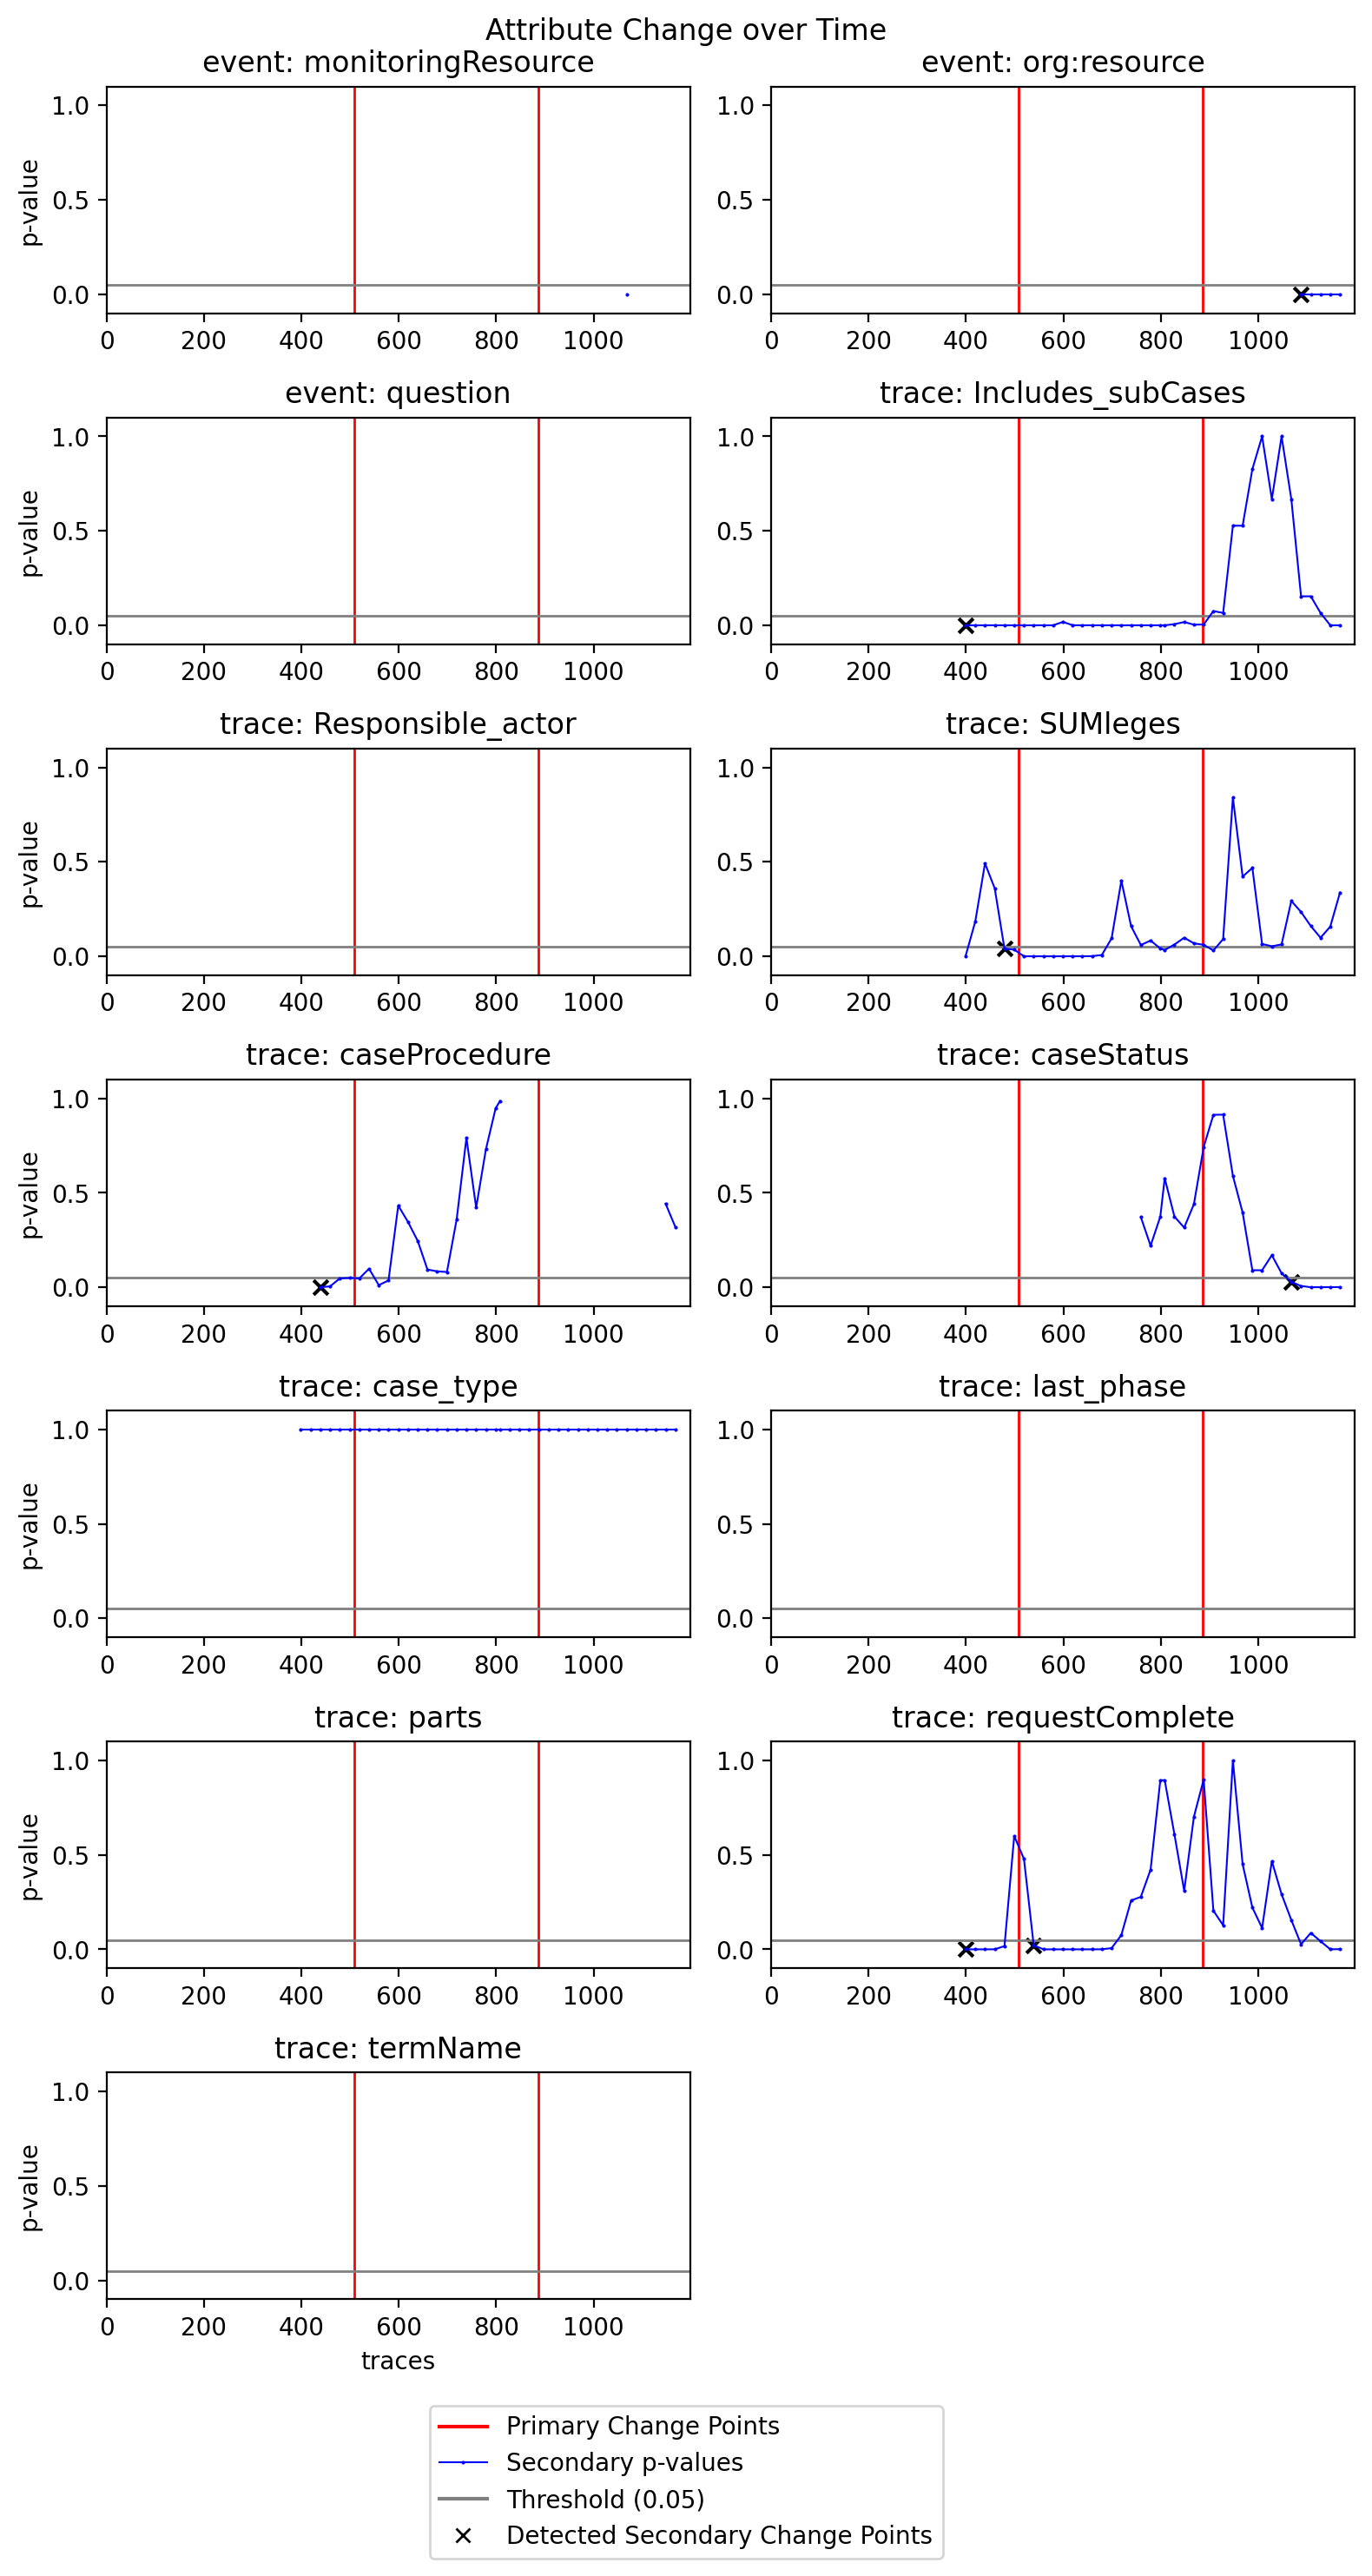

In [ ]:
# plot the change point explanations for municipal 1
changes_per_mun['mun_1'].plot(offset_legend=-0.07)
pass

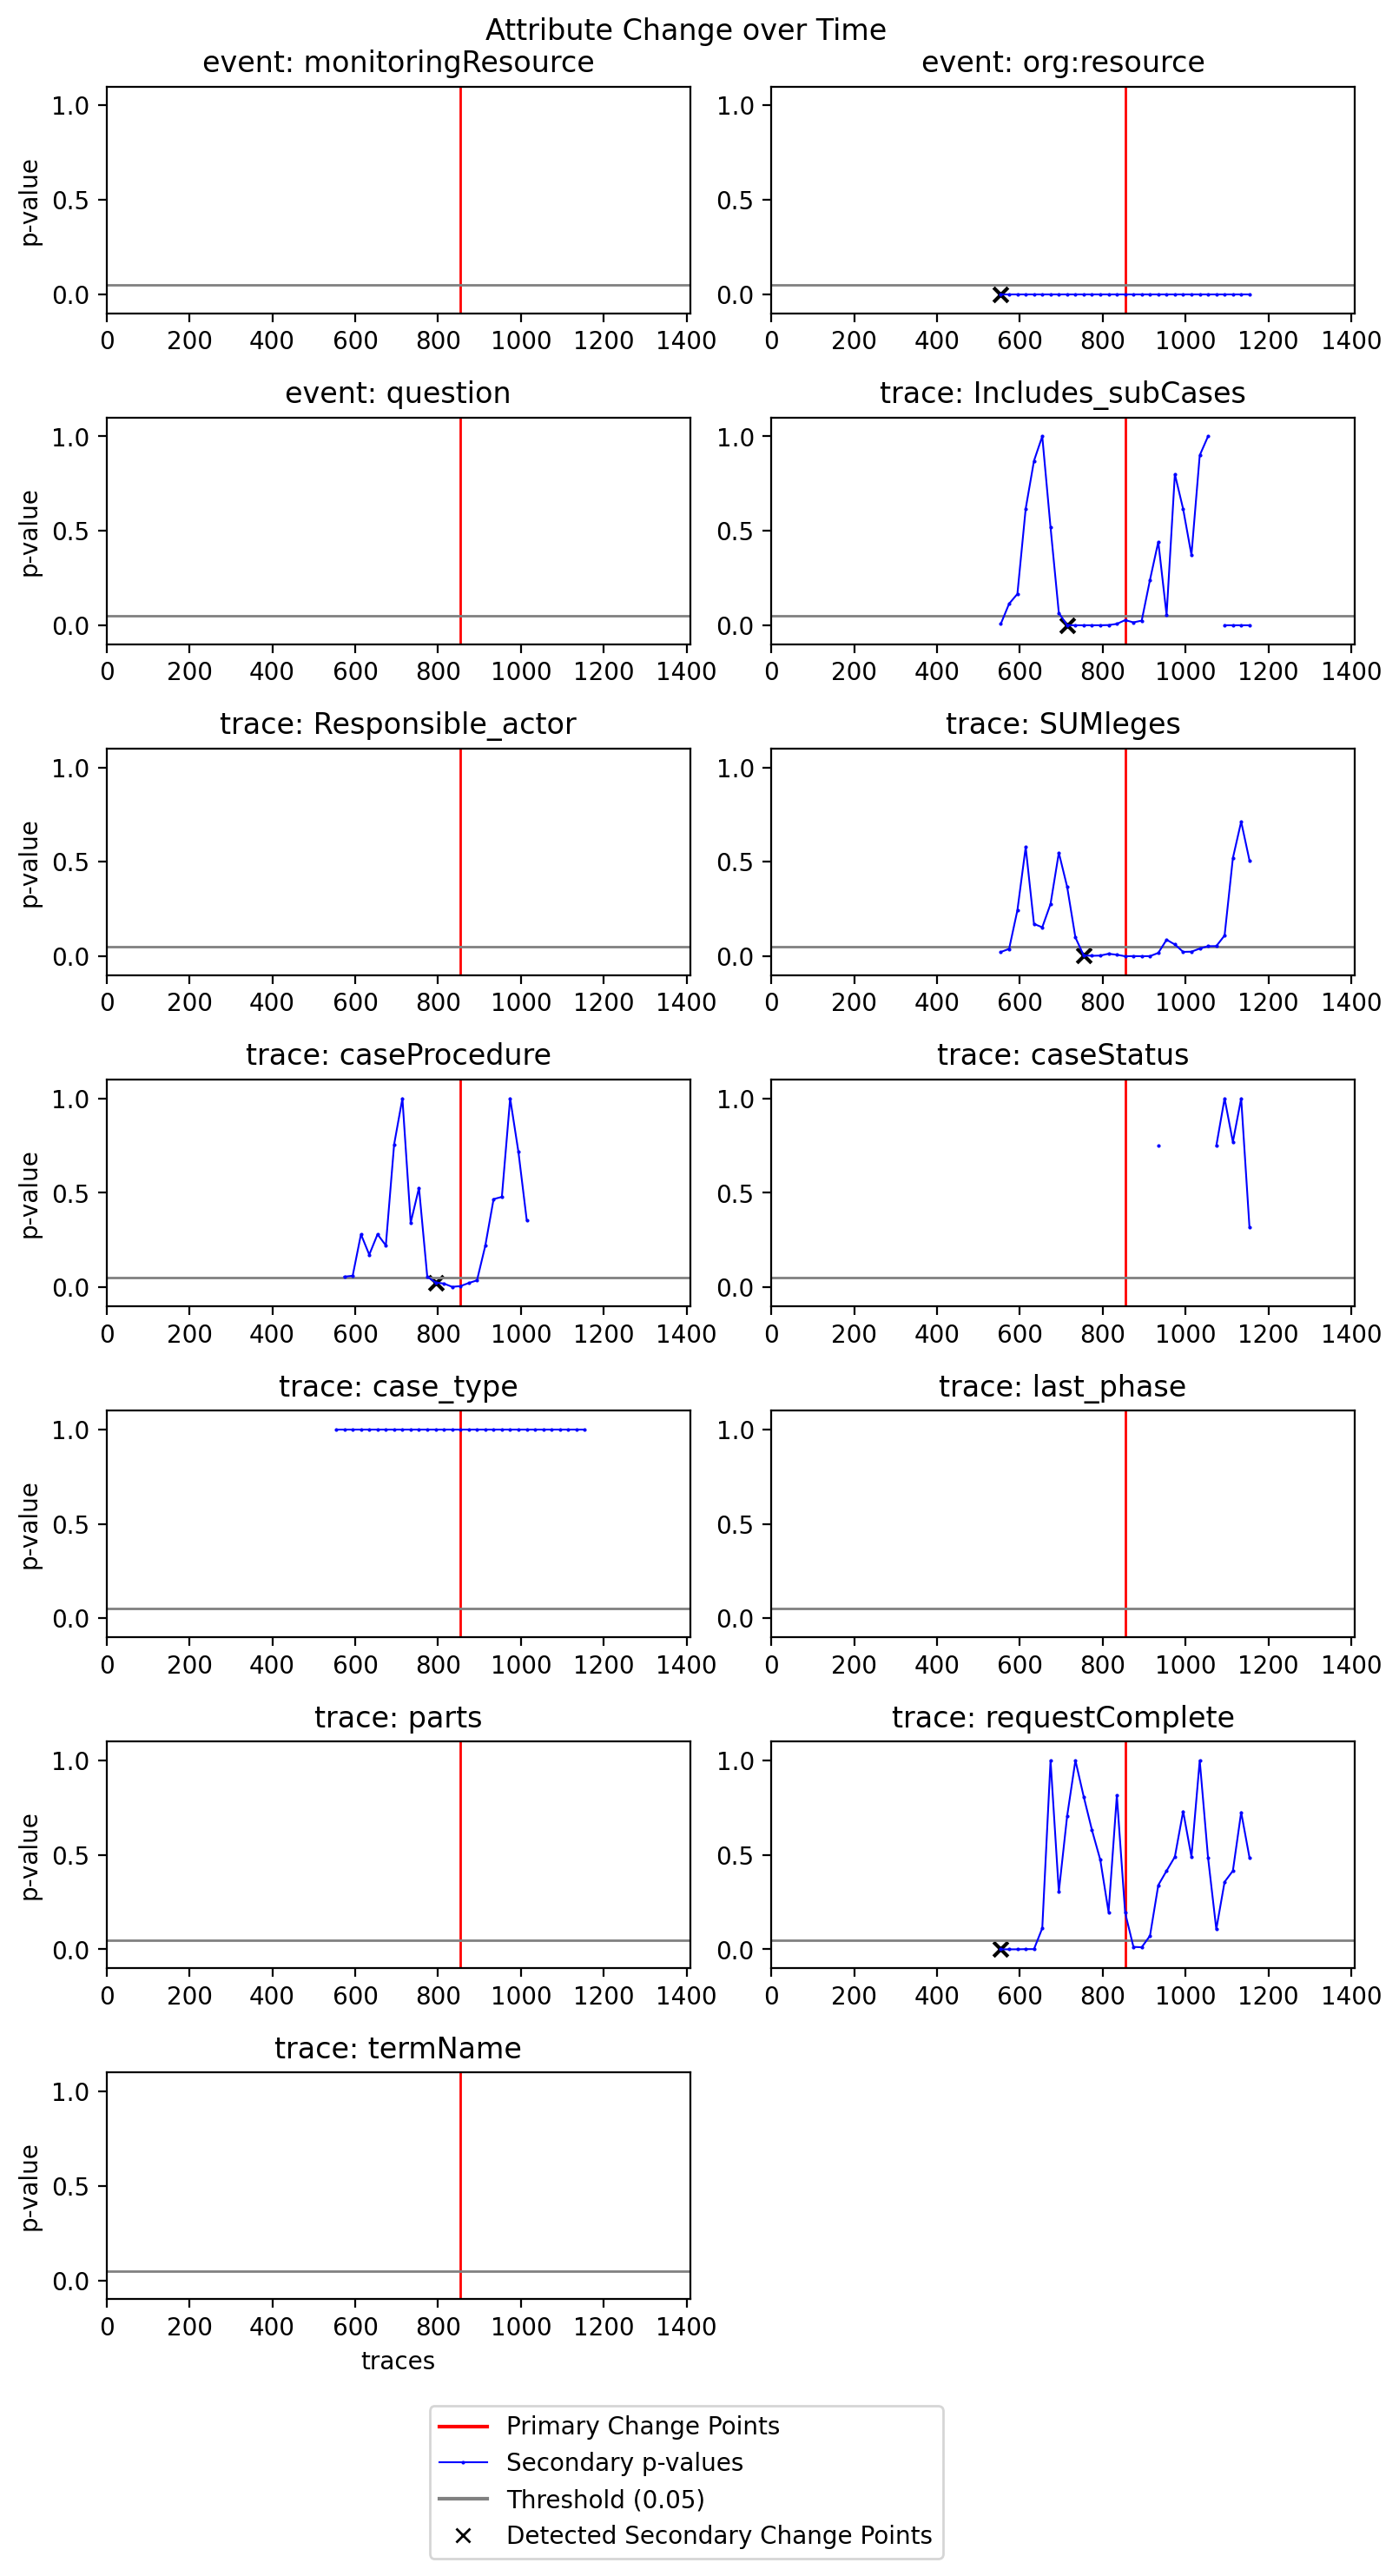

In [ ]:
# plot the change point explanations for municipal 3
changes_per_mun['mun_3'].plot(offset_legend=-0.07)
pass

Create new plots for both municipals with only the change series that have (mostly) measurable p-values.

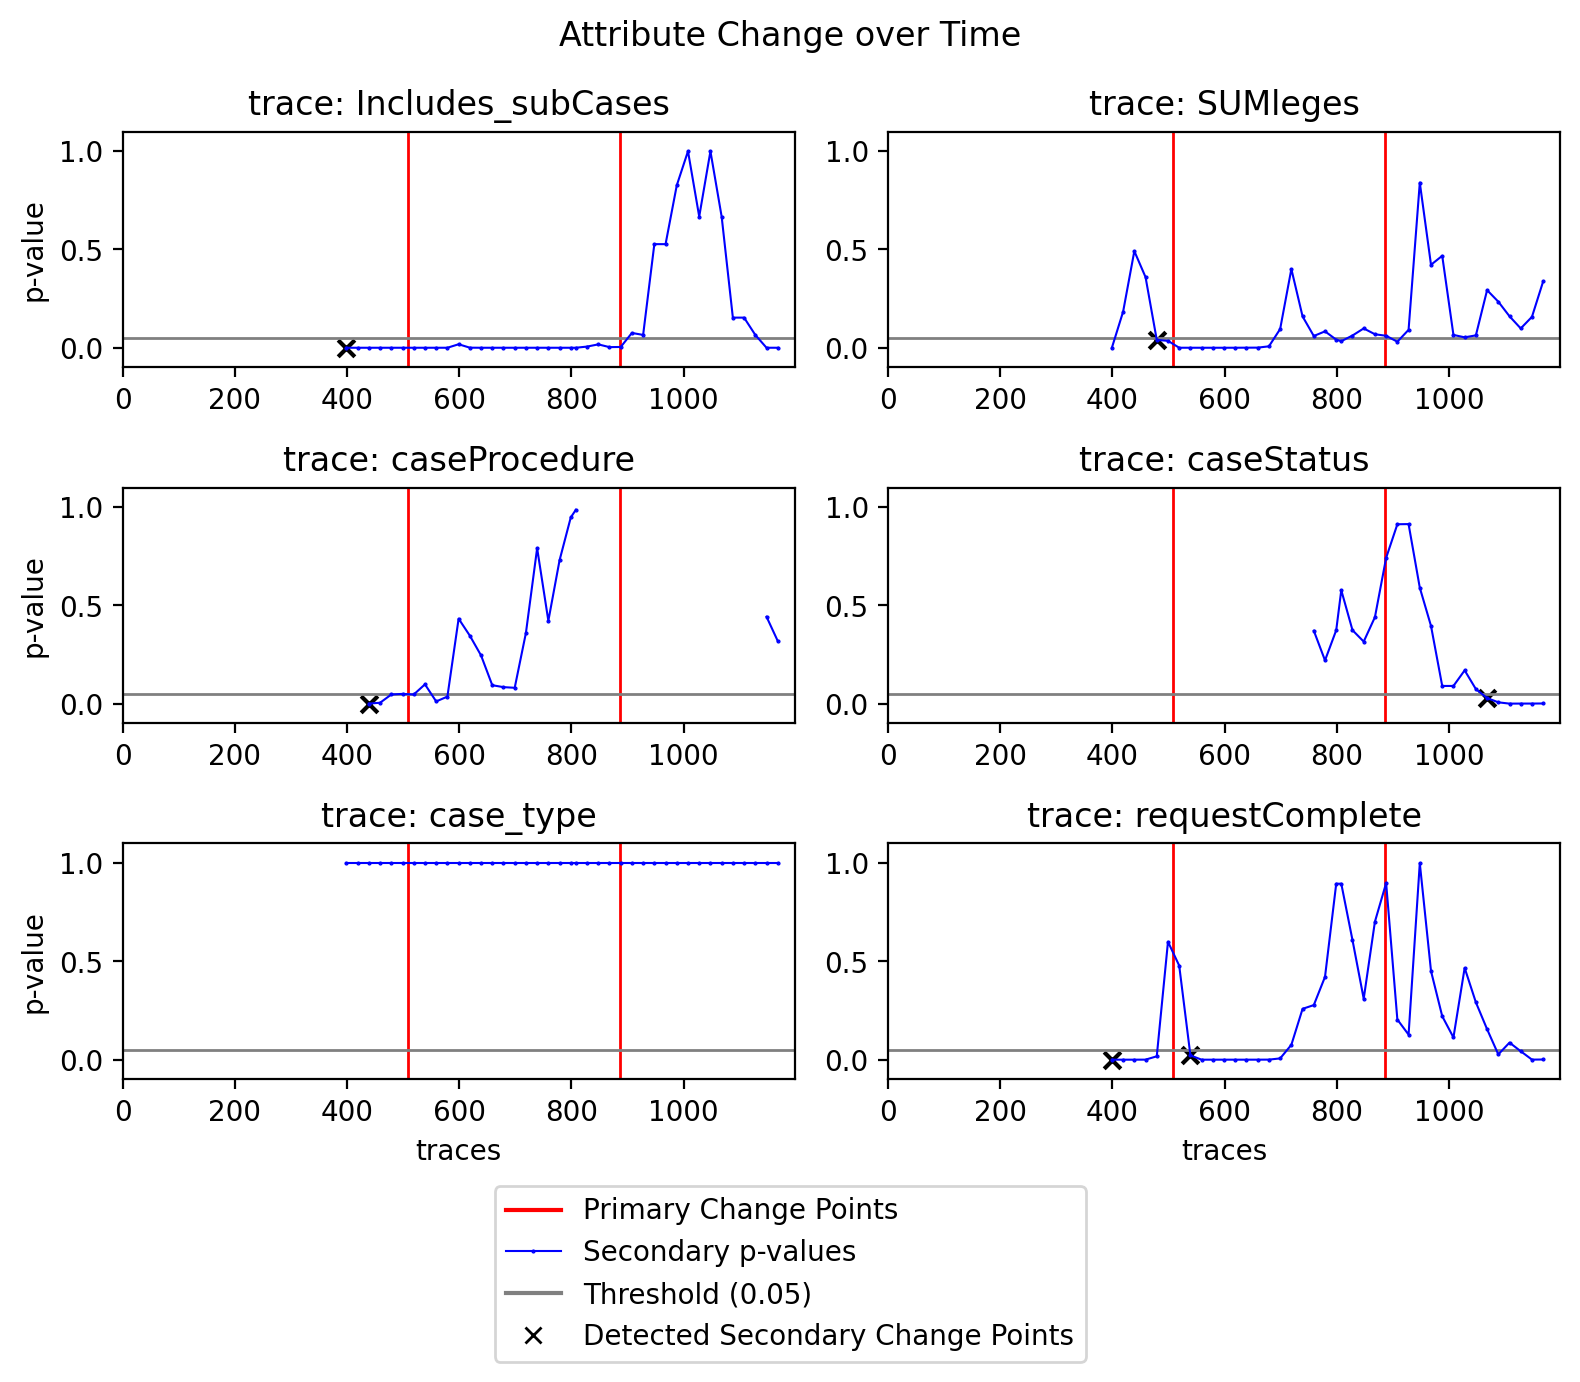

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
# plot only change series with enough measurements, municipal 1
from operator import itemgetter

secondary_dd_list_mun_1 = ['trace: Includes_subCases',
 'trace: SUMleges',
 'trace: caseProcedure',
 'trace: case_type',
 'trace: caseStatus',
 'trace: requestComplete']

# get the according drift detectors
mun_1_selected_drift_detectors = {secondary_dd: changes_per_mun['mun_1'].secondary_dd_result_dictionary[secondary_dd] for secondary_dd in secondary_dd_list_mun_1}

# build a new drift explanation objects
drift_explanations_mun_1 = drift_explanation.DriftExplanationResult(changes_per_mun['mun_1'].primary_dd_result, mun_1_selected_drift_detectors, None)

drift_explanations_mun_1.plot()

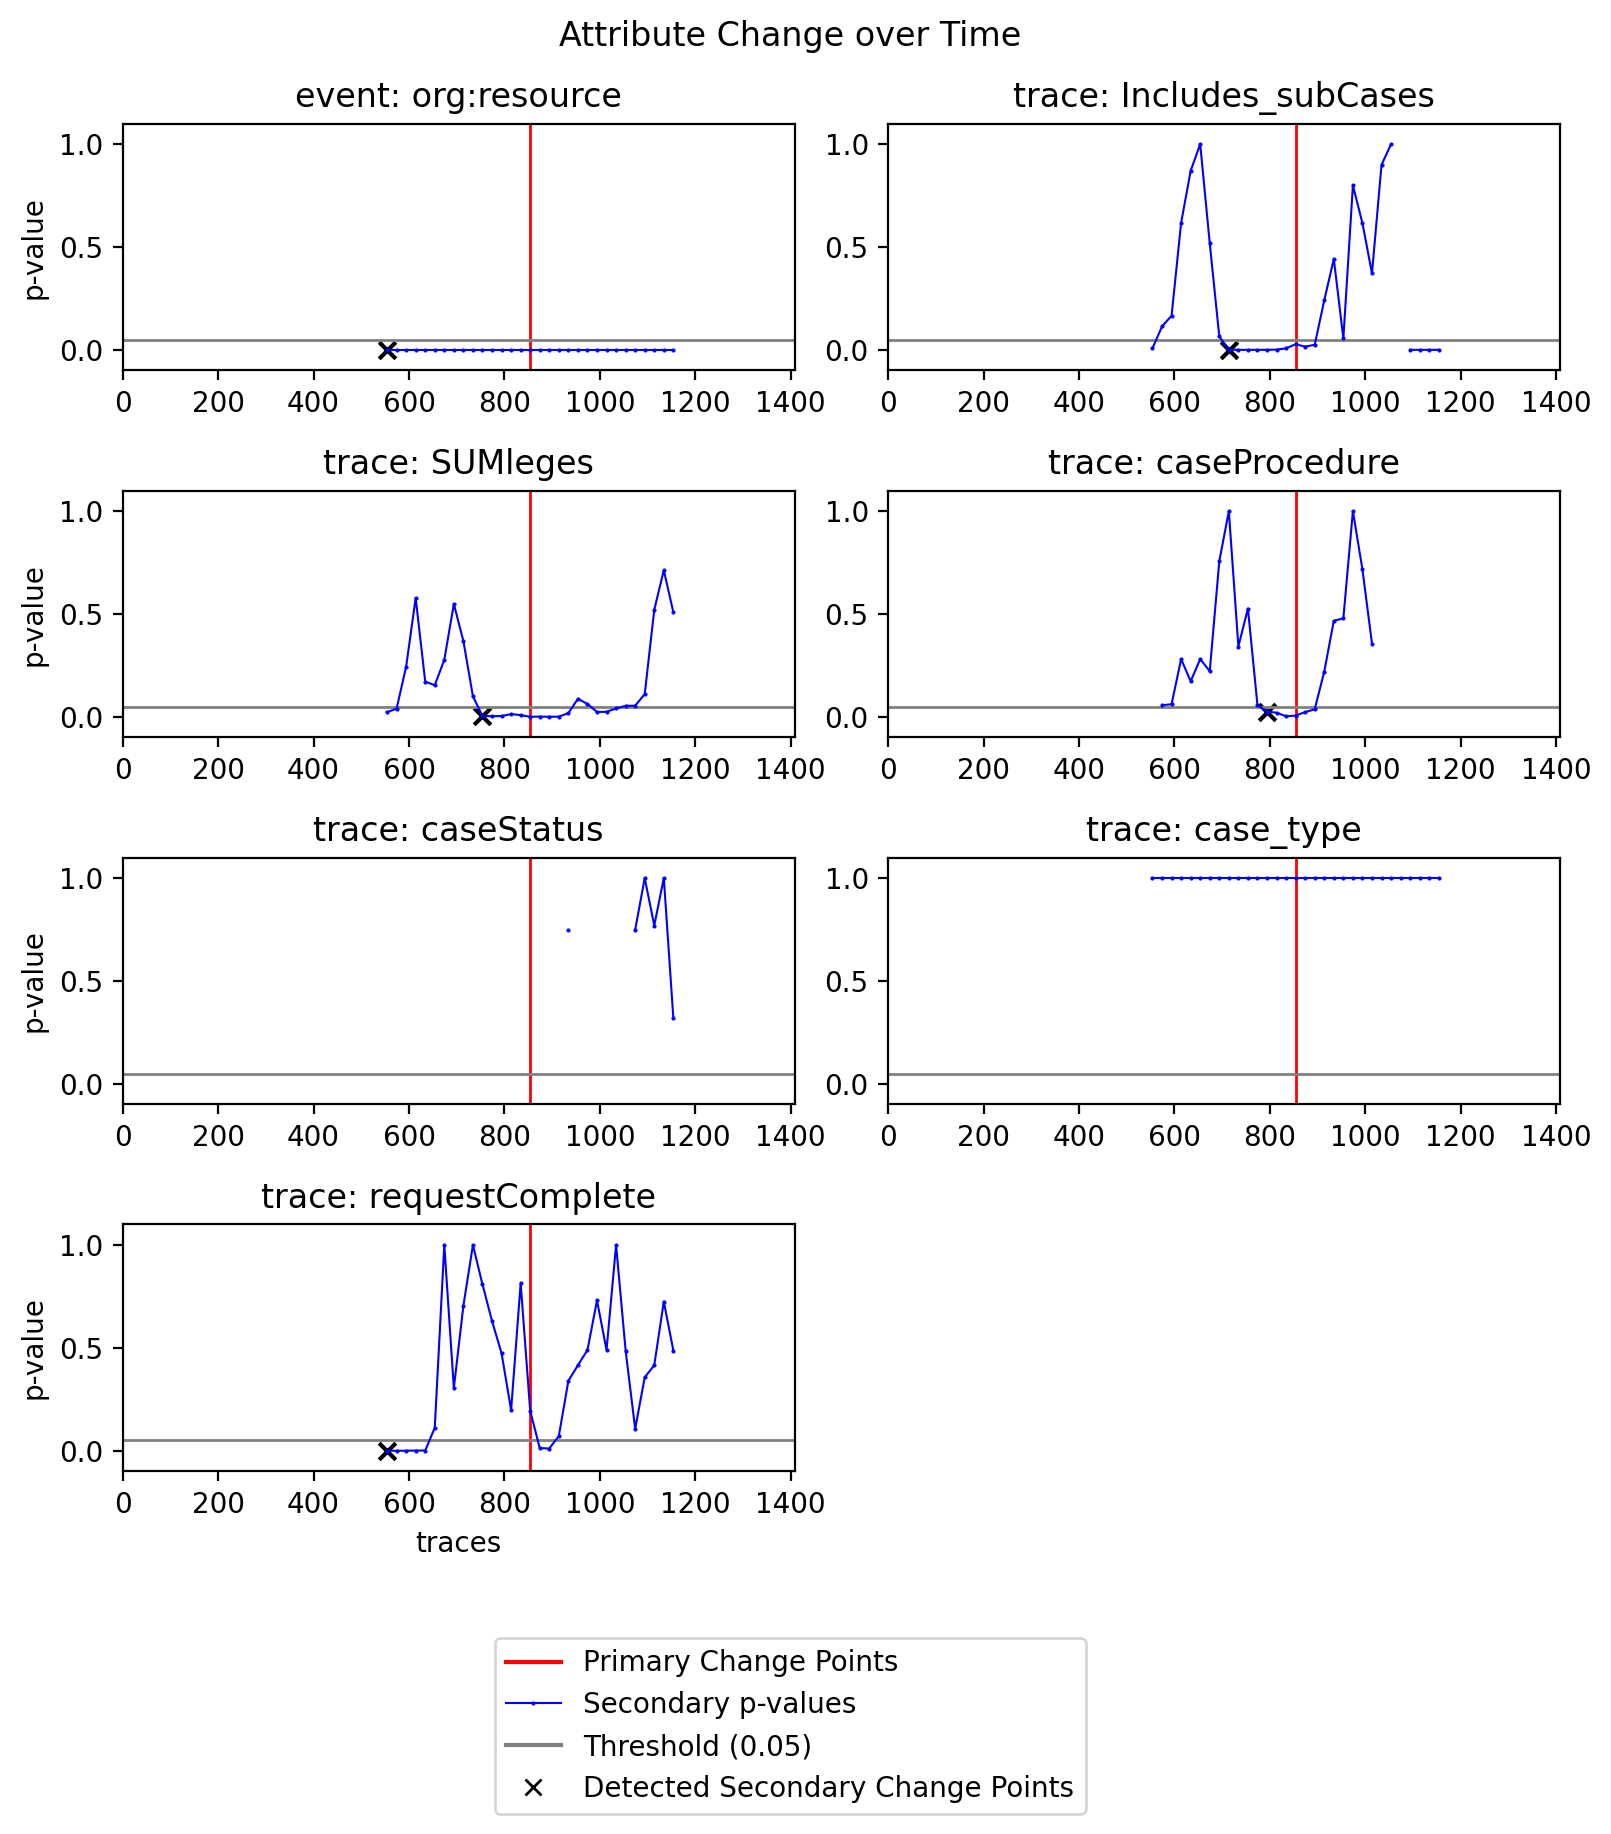

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
# plot only change series with enough measurements, municipal 3
from operator import itemgetter

secondary_dd_list_mun_3 = [
 'event: org:resource',
 'trace: Includes_subCases',
 'trace: SUMleges',
 'trace: caseProcedure',
 'trace: case_type',
 'trace: caseStatus',
 'trace: requestComplete']

# get the according drift detectors
mun_3_selected_drift_detectors = {secondary_dd: changes_per_mun['mun_3'].secondary_dd_result_dictionary[secondary_dd] for secondary_dd in secondary_dd_list_mun_3}

# build a new drift explanation objects
drift_explanations_mun_3 = drift_explanation.DriftExplanationResult(changes_per_mun['mun_3'].primary_dd_result, mun_3_selected_drift_detectors, None)

drift_explanations_mun_3.plot()

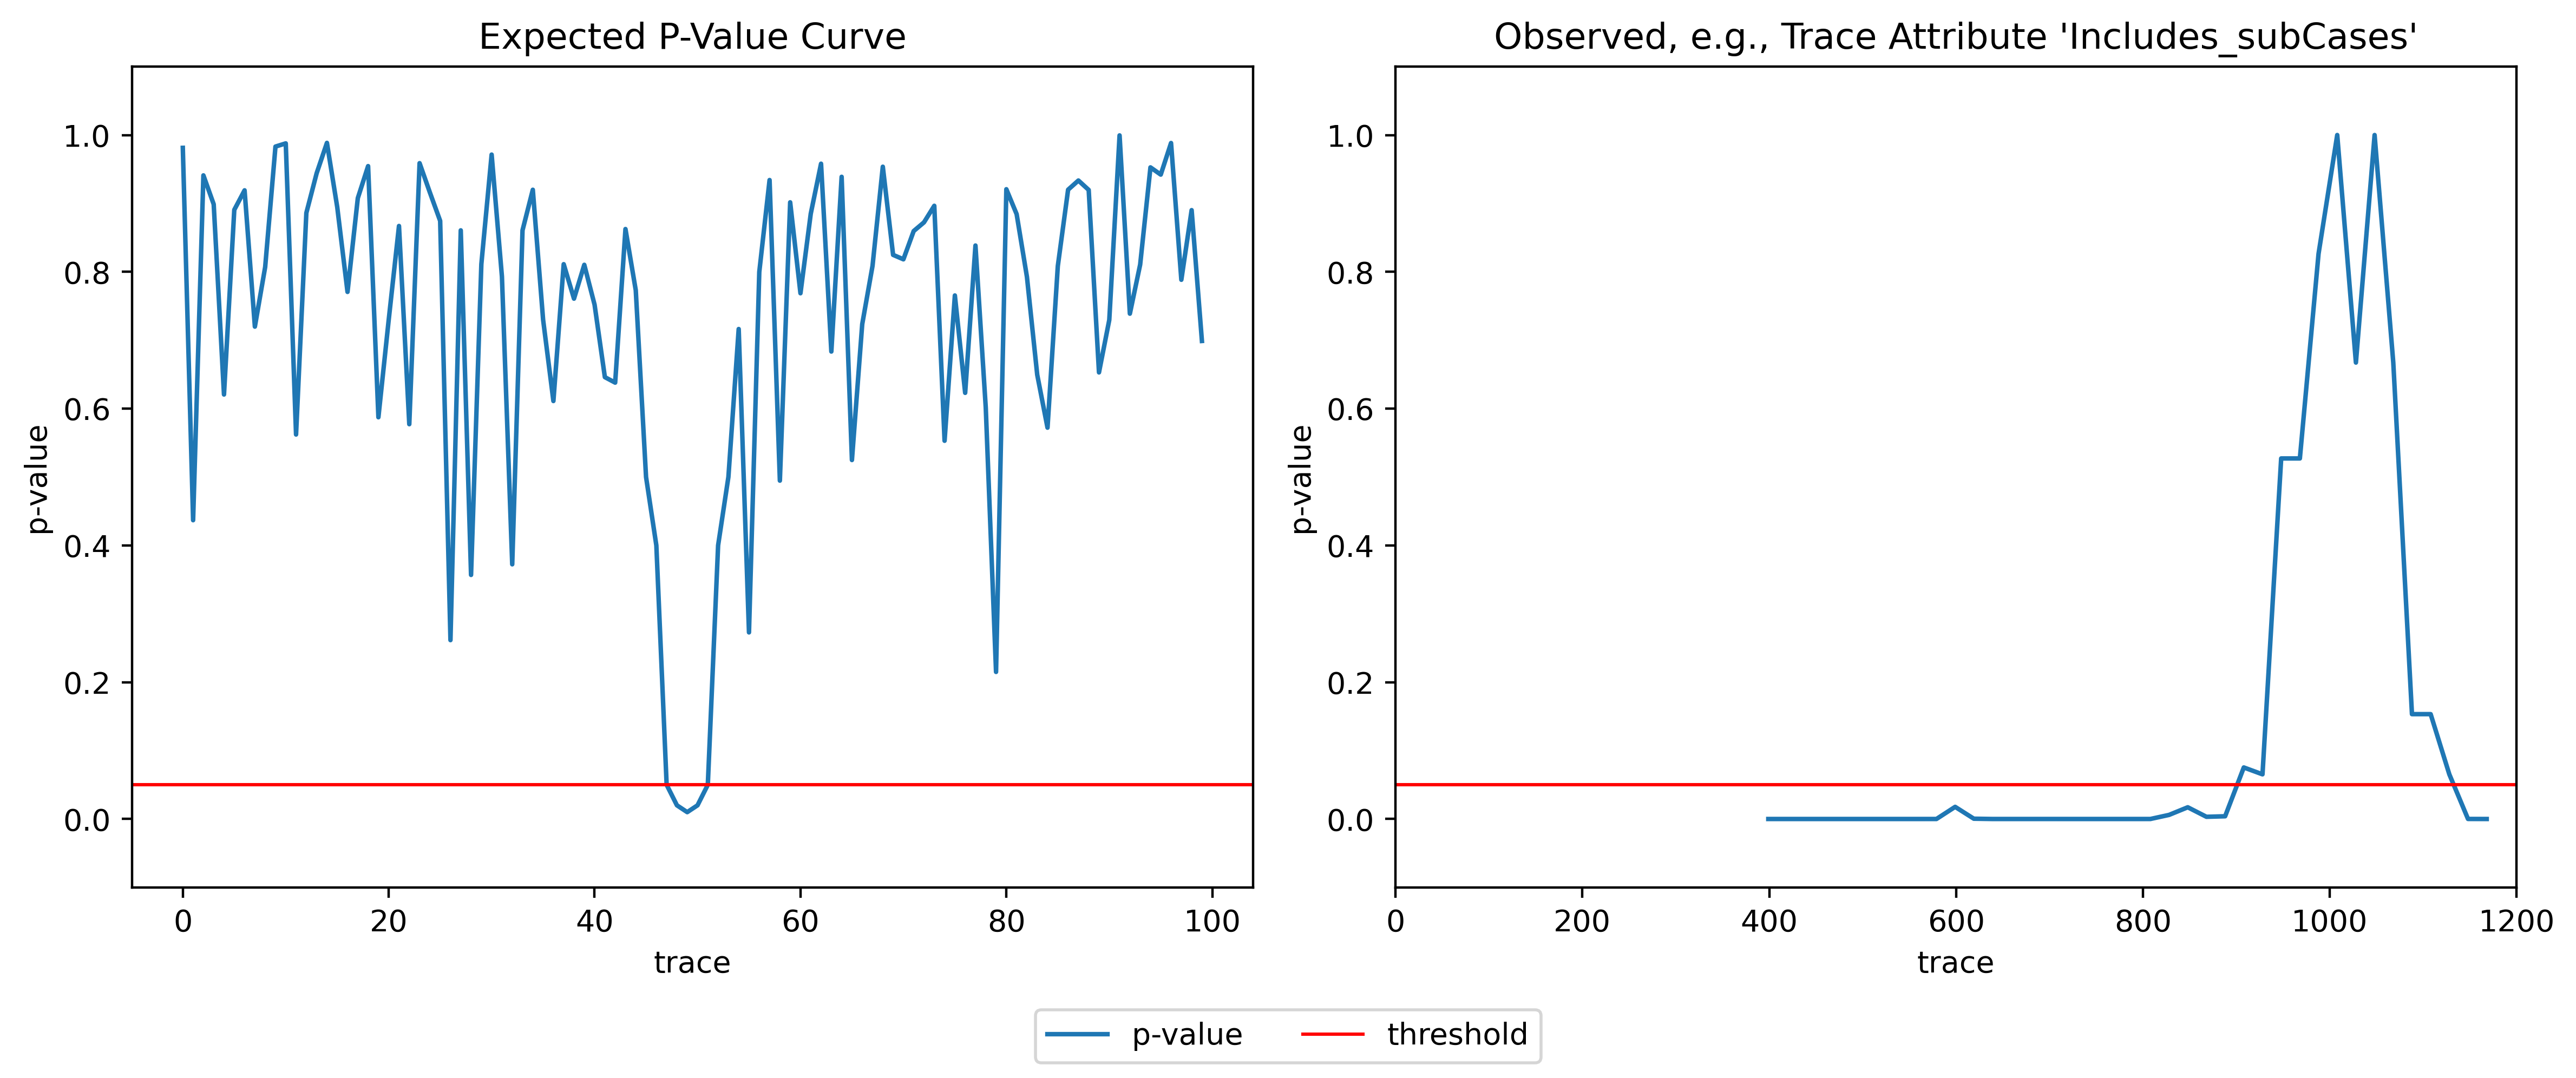

In [20]:
# show a graph with two sub-figures - the idealized p-value graph and the observed graph
fig = plt.figure(figsize=(12, 5), dpi=400)
# fig.suptitle('Comparison Between Expected P-Value Curve and Observed')


#### Build subplot for ideal p-value recording
plt.subplot(1, 2, 1)

# show an idealized p-value graph
import math
import matplotlib.pyplot as plt

array = np.ones(100)

# add some random noise
array = [value - abs(np.random.normal(0, 0.3)) for value in array]

# add the drop of p-value for around point 50
array[45] = 0.5
array[46] = 0.4
array[47] = 0.05
array[48] = 0.02
array[49] = 0.01
array[50] = 0.02
array[51] = 0.05
array[52] = 0.4
array[53] = 0.5

# convert to pandas series for plotting
pd.Series(array).plot(title='Expected P-Value Curve',
                    ylabel='p-value',
                    xlabel='trace')
plt.ylim(-0.1, 1.1)
plt.axhline(0.05, color='red', linewidth=1.1)

#### Show subplot for actual recorded p-values
plt.subplot(1, 2, 2)

# get a change series
change_series = changes_per_mun['mun_1'].secondary_dd_result_dictionary['trace: Includes_subCases'].change_series
change_series.plot(title='Observed, e.g., Trace Attribute \'Includes_subCases\'',
                    ylabel='p-value',
                    xlabel='trace')

plt.ylim(-0.1, 1.1)
plt.xlim(0, 1200)

threshold_line = plt.axhline(0.05, color='red', linewidth=1.1, label='threshold')

fig.tight_layout() 
fig.subplots_adjust(bottom=0.17)   ##  Need to play with this number.

fig.legend(labels=['p-value', 'threshold'], loc="lower center", ncol=2)

#plt.tight_layout()

plt.show()


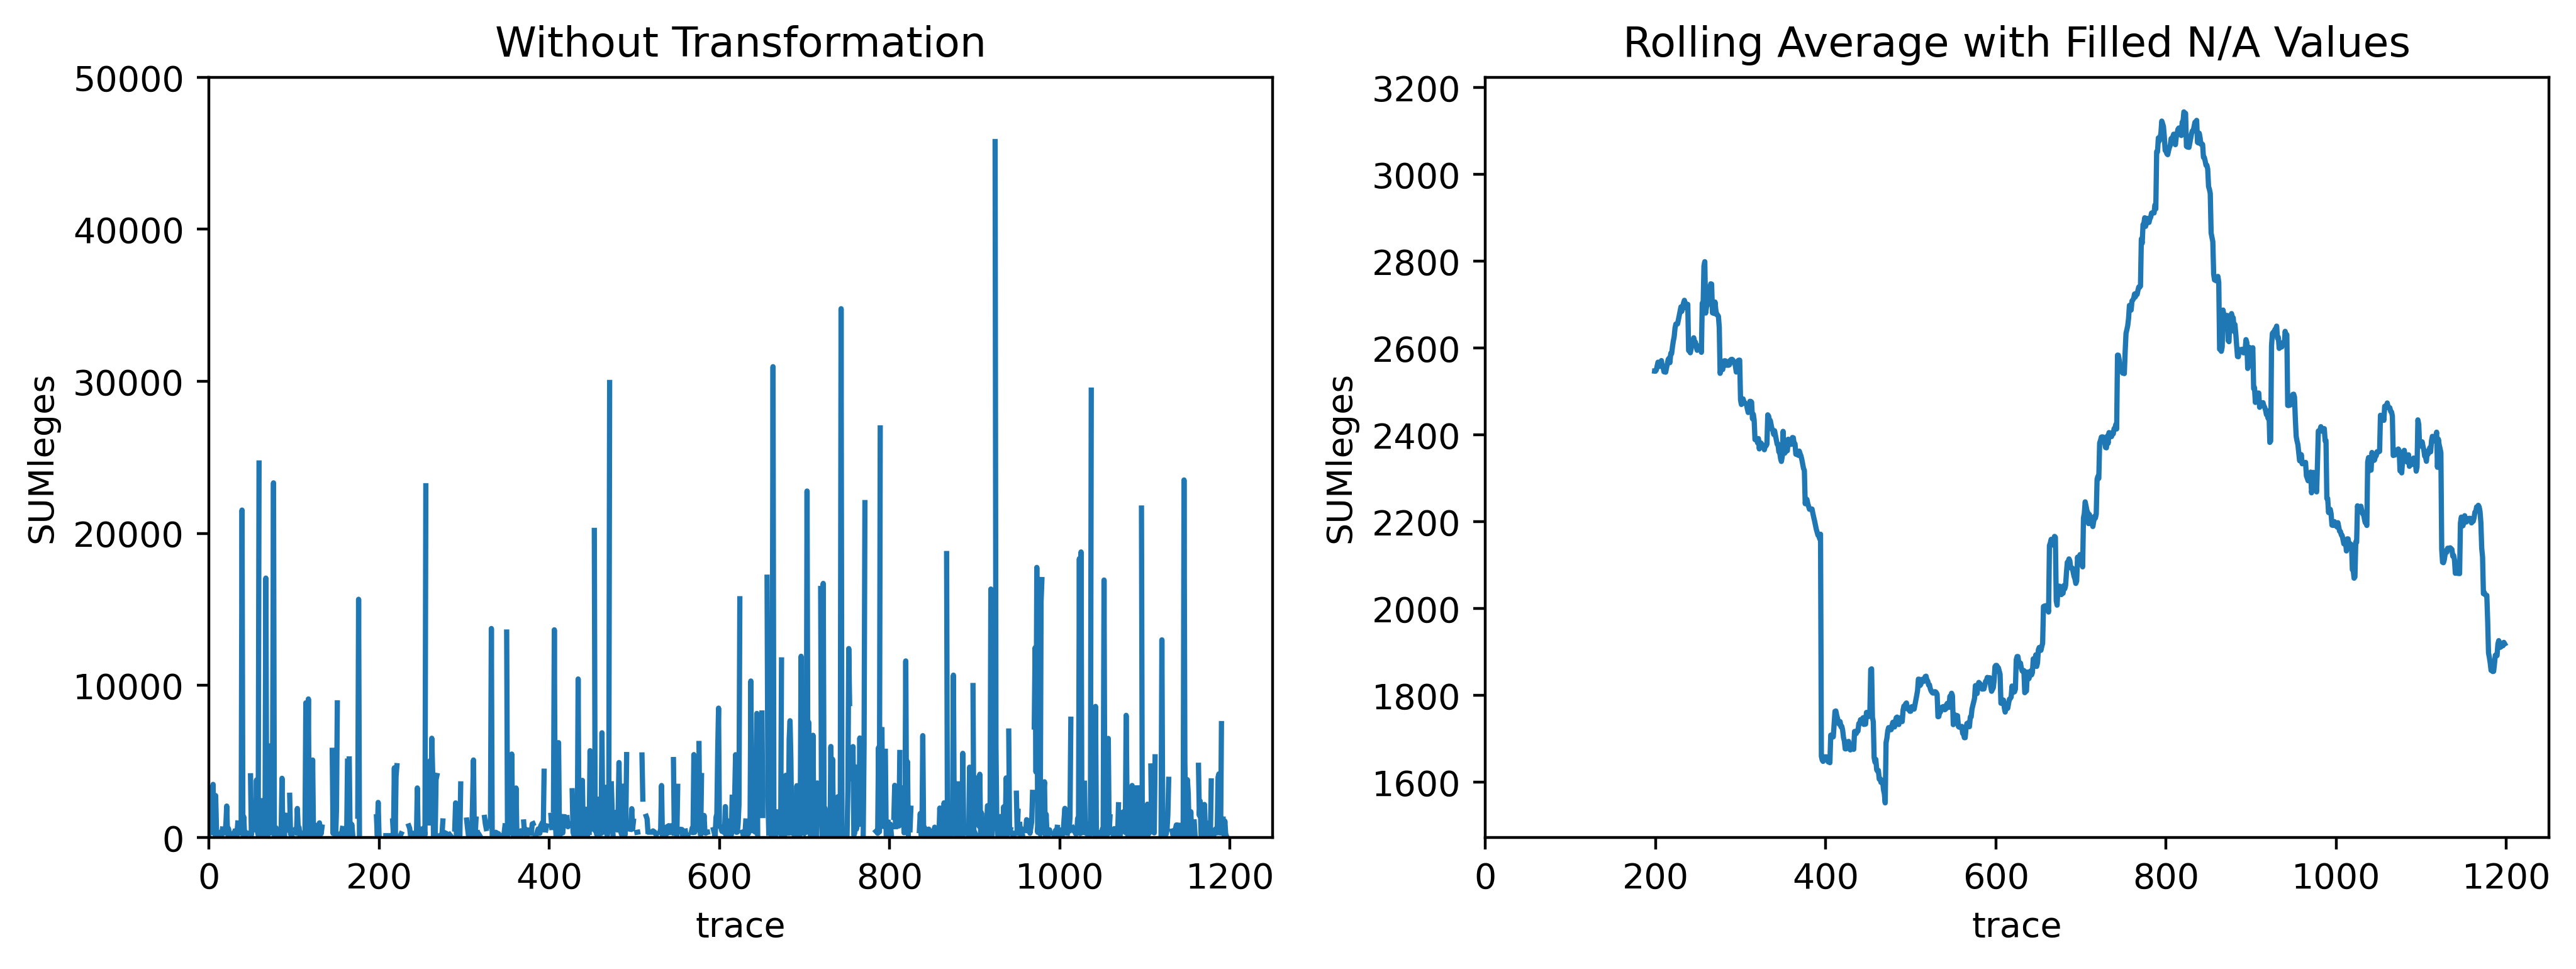

In [29]:
# maybe just showing the moving average of SUMleges provides further insights
fig = plt.figure(figsize=(12, 4), dpi=400)
# fig.suptitle('SUMleges per Trace')

plt.subplot(1, 2, 1)

fe = feature_extraction.AttributeFE('trace', 'SUMleges')
sumleges_values = fe.extract(event_logs['mun_1'])
sumleges_series = pd.Series(sumleges_values)

sumleges_series.plot()
plt.ylim(0, 50000)
plt.xlim(0, 1250)
plt.ylabel('SUMleges')
plt.xlabel('trace')
plt.title('Without Transformation')

# second subplot with rolling average and filled na values
plt.subplot(1, 2, 2)

sumleges_series_fillna = sumleges_series.fillna(sumleges_series.mean())
sumleges_ma = sumleges_series_fillna.rolling(200, min_periods=200, center=False).mean()
sumleges_ma.plot()
# plt.ylim(0, 50000)
plt.xlim(0, 1250)
plt.ylabel('SUMleges')
plt.xlabel('trace')
plt.title('Rolling Average with Filled N/A Values')

plt.tight_layout()
plt.show()

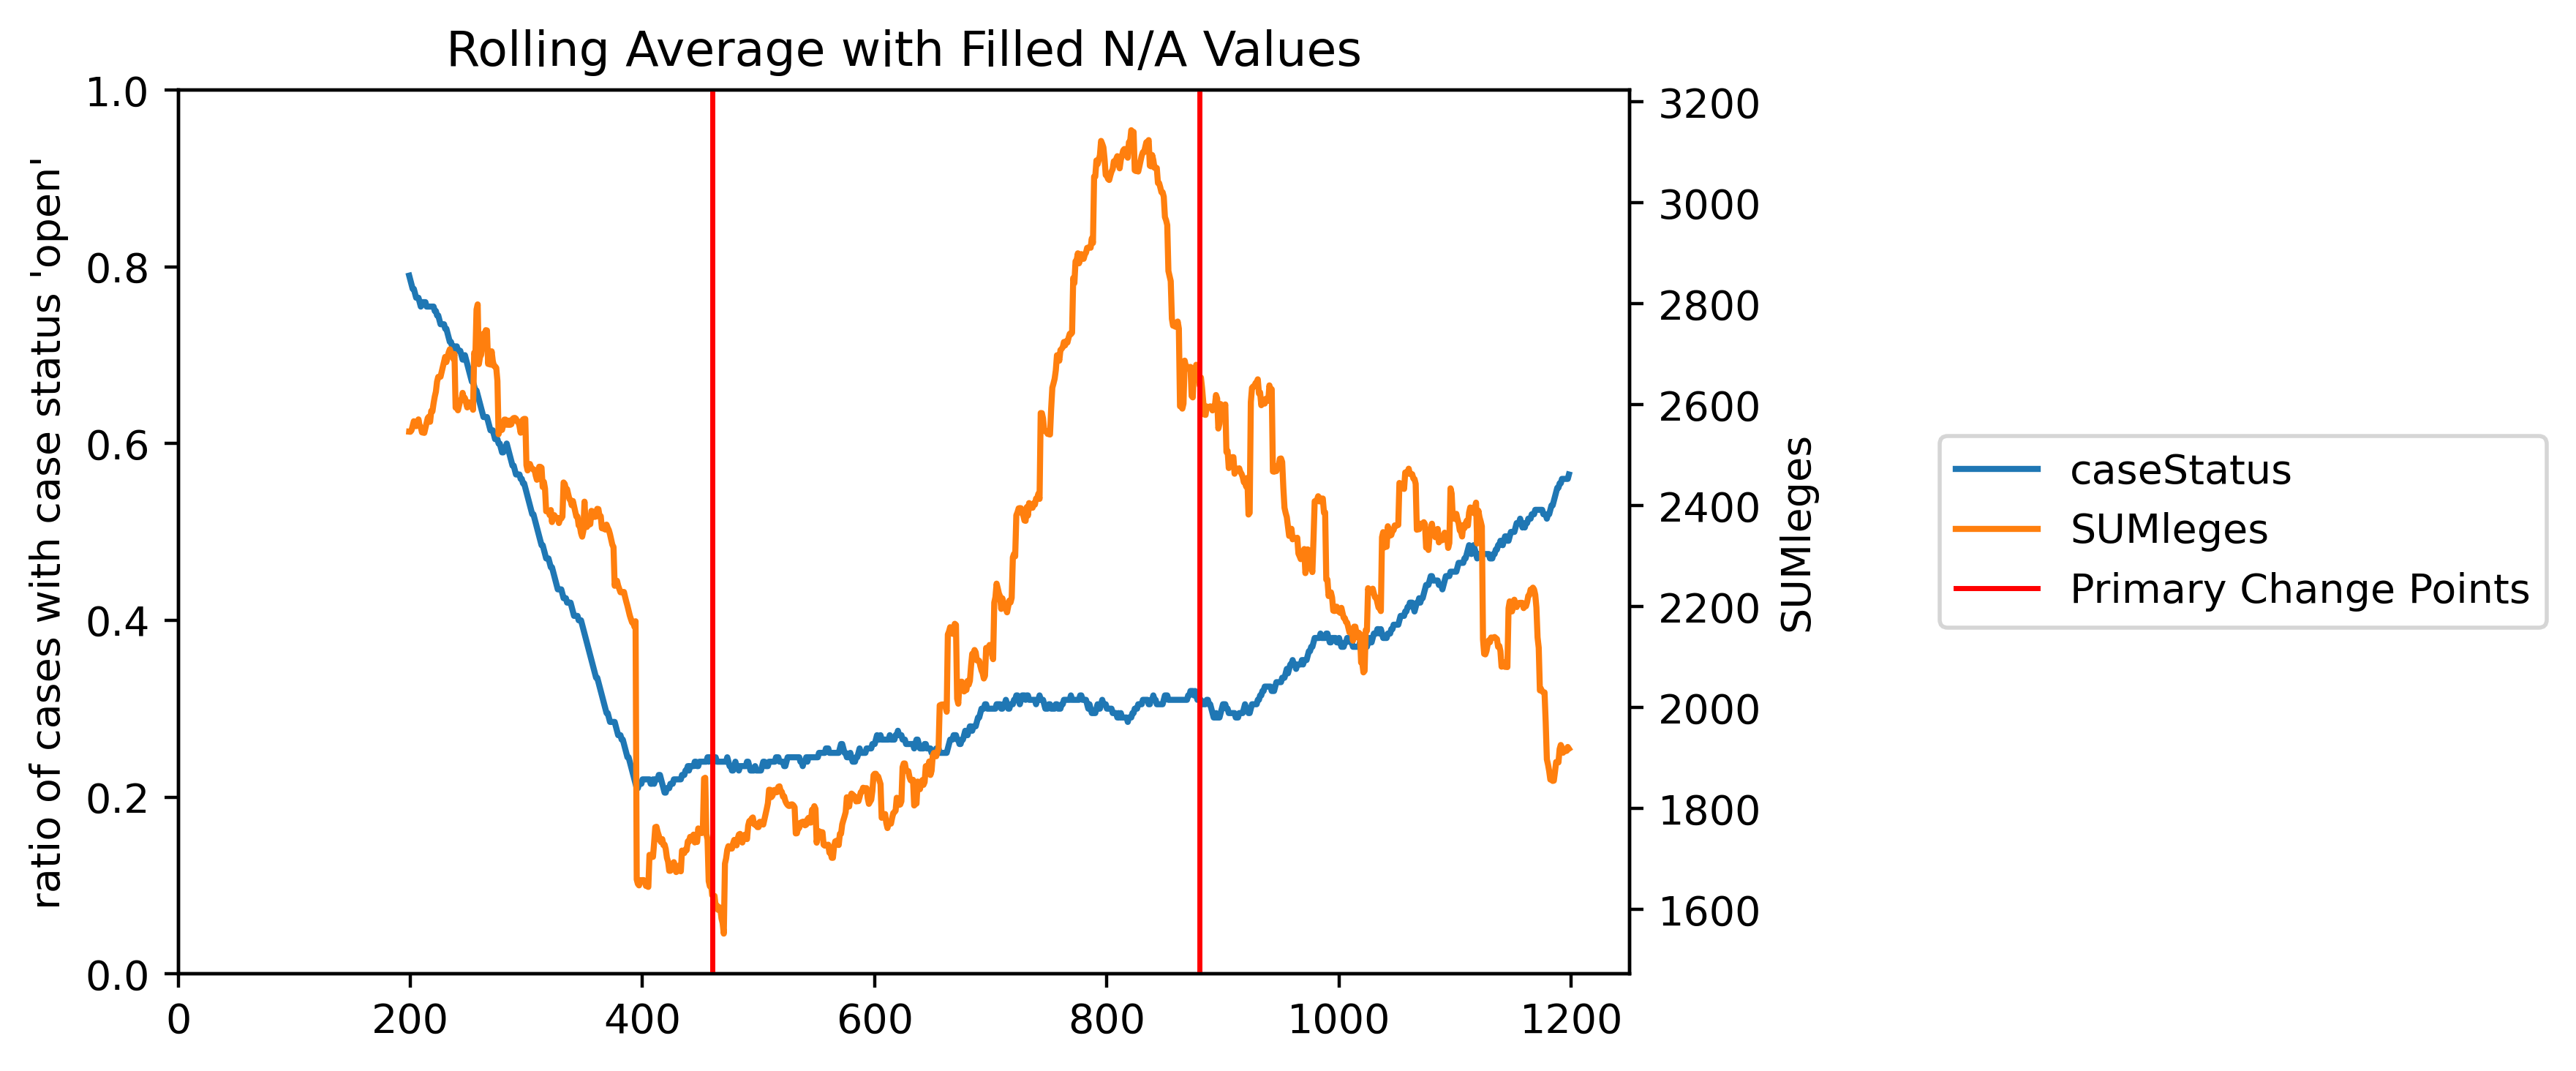

In [27]:
# plot the ratio of open cases for municipal 1
# plot first axis
fig = plt.figure(figsize=(8, 4), dpi=400)



fe = feature_extraction.AttributeFE('trace', 'caseStatus')
casestatus_values = fe.extract(event_logs['mun_1'])
casestatus_series = pd.Series(casestatus_values)
casestatus_series = (casestatus_series == 'O')
casestatus_series = casestatus_series.astype('int')

casestatus_series_fillna = casestatus_series.fillna(casestatus_series.mean())
casestatus_ma = casestatus_series_fillna.rolling(200, min_periods=200, center=False).mean()
ax1 = casestatus_ma.plot()
plt.ylim(0, 1)
plt.xlim(0, 1250)
plt.ylabel('ratio of cases with case status \'open\'')

# add the change point line
ax2 = sumleges_ma.plot(secondary_y=True)
plt.ylabel('SUMleges')
plt.xlabel('trace')

ax2.axvline(460, color='red', linewidth=1.25, label='Change Point')
ax2.axvline(880, color='red', linewidth=1.25)

lines_1, _ = ax1.get_legend_handles_labels()
lines_2, _ = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = ['caseStatus', 'SUMleges', 'Primary Change Points']


plt.title('Rolling Average with Filled N/A Values')

# Shrink current axis by 20%
box = ax2.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax1.legend(lines, labels,loc='center left', bbox_to_anchor=(1.2, 0.5))

# plt.tight_layout()

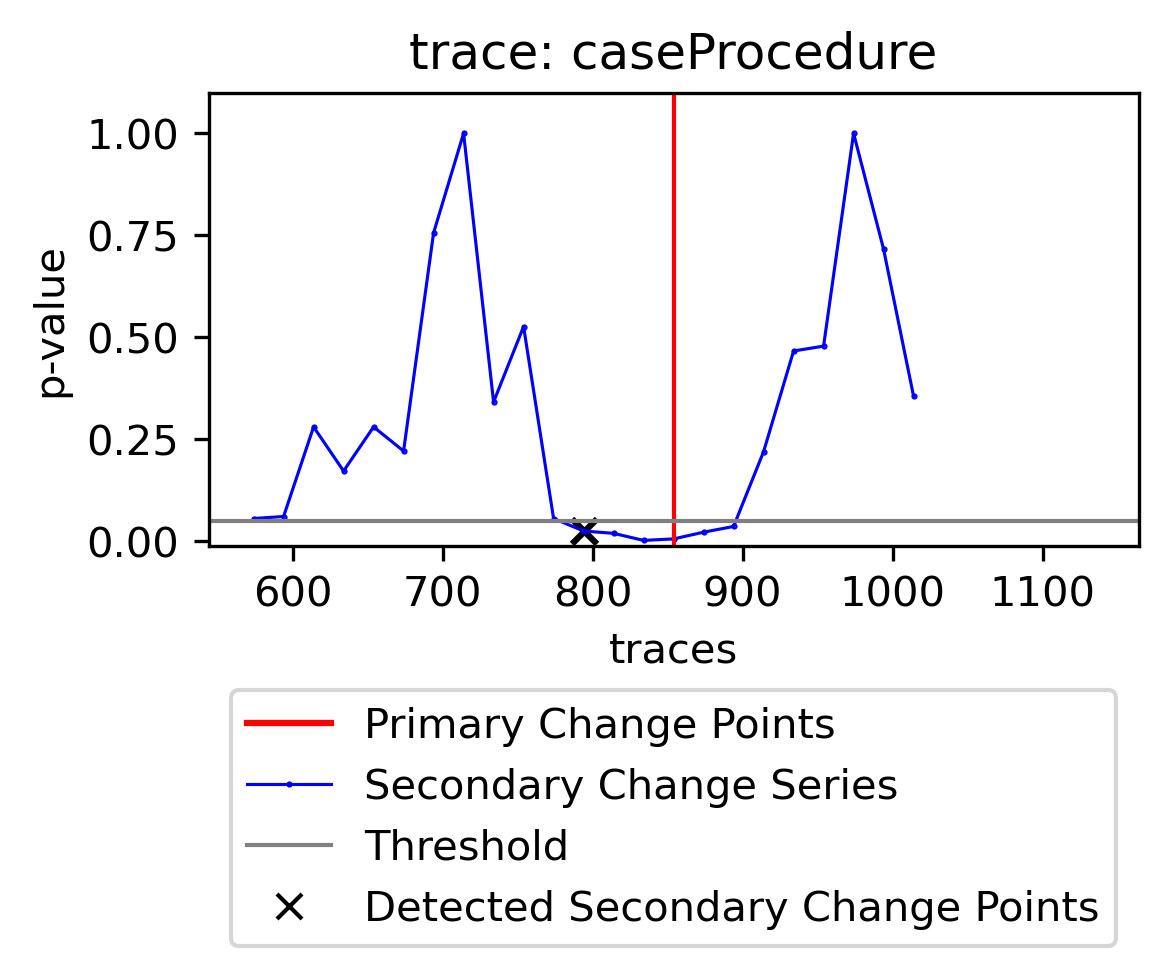

In [37]:
# print the case procedure p-value curve
changes_per_mun['mun_3'].secondary_dd_result_dictionary['trace: caseProcedure'].plot(primary_change_points=changes_per_mun['mun_3'].primary_dd_result.change_points, threshold=0.05, start=0, end=1400, offset_legend=-0.93, ylabel='p-value')

In [ ]:
# show the positions of highest p-values for the caseProcedure attribute
changes_per_mun['mun_3'].secondary_dd_result_dictionary['trace: caseProcedure'].change_series.sort_values(ascending=False)[:5]

713    1.000000
973    1.000000
693    0.877713
993    0.716177
753    0.526523
dtype: float64

In [ ]:
# get the data from the two windows before/after the steady state
window_1_start = 314
window_1_end = 713
window_2_start = 574
window_2_end = 973

# extract the attributes for each data window
# build an attribute feature extractor
fe = feature_extraction.AttributeFE('trace', 'caseProcedure')
event_log = event_logs['mun_3']

# extract the attribute arrays
attribute_values_window_1_array = fe.extract(event_log[window_1_start:window_1_end+1])
attribute_values_window_2_array = fe.extract(event_log[window_2_start:window_2_end+1])

# construct into series with correct trace indeces
attribute_values_window_1 = pd.Series(attribute_values_window_1_array, index=range(window_1_start, window_1_end+1))
attribute_values_window_2 = pd.Series(attribute_values_window_2_array, index=range(window_2_start, window_2_end+1))

# replace None values with string 'None' for plotting purposes
attribute_values_window_1 = attribute_values_window_1.fillna('None')
attribute_values_window_2 = attribute_values_window_2.fillna('None')

# show unique values
value_counts_win_1 = attribute_values_window_1.value_counts()
value_counts_win_2 = attribute_values_window_2.value_counts()

print('Value Counts Window 1')
display(value_counts_win_1)
print('Value Counts Window 2')
display(value_counts_win_2)

# build a results dataframe
df = pd.DataFrame([value_counts_win_1, value_counts_win_2], index=['Before CP', 'After CP']).transpose()
df.loc['Uitgebreid Ratio'] = df.loc['Uitgebreid'] / df.sum()
display(df)

# write to latex table
path = 'results/latex/bpic_2015_mun_3_case_procedure.tex'
with open(path, 'w') as file:
    df.to_latex(file, float_format="%.2f")

Value Counts Window 1


None          356
Uitgebreid     44
dtype: int64

Value Counts Window 2


None          366
Uitgebreid     34
dtype: int64

,Before CP,After CP
None,356.00,366.000
Uitgebreid,44.00,34.000
Uitgebreid Ratio,0.11,0.085


C:\Users\Lennart\AppData\Local\Temp\ipykernel_18772\840381614.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(file, float_format="%.2f")
